#  Decision Tree Classifier — From Scratch

In this notebook, we implement a **Decision Tree Classifier** completely from scratch using **NumPy only**.

We will:

- Generate a synthetic dataset  
- Implement entropy and information gain  
- Build the tree recursively  
- Create decision nodes and leaf nodes  
- Predict using the constructed tree  
- Visualize classification regions  
- Evaluate model accuracy  

---


## What is a Decision Tree?

A Decision Tree is a **non-parametric supervised learning algorithm** used for classification and regression.  
The idea is to split the dataset into smaller subsets based on the feature values that produce the **purest split**.

A node splits the data based on a question like:

> *"Is feature₁ ≤ 2.5?"*

The goal of each split is to increase **purity** (i.e., reduce entropy).

---

##  Entropy

Entropy measures the amount of impurity in the dataset:

$$
H(p) = - \sum_{i=1}^{k} p_i \log_2(p_i)
$$

Where:  
- $p_i$ = proportion of class *i*  
- Higher entropy → more mixed classes  
- Lower entropy → cleaner/single-class region  

---

##  Information Gain

To choose the best split, the tree tries to **maximize**:

$$
\text{Information Gain} = H(\text{parent}) - 
\sum_{j} \frac{n_j}{n} H(\text{child}_j)
$$

Where:  
- $n$ = number of samples  
- $n_j$ = samples in each child after splitting  

The best split is the one that **reduces entropy** the most.

---

##  Decision Tree Steps

1. Calculate entropy of the current node  
2. Try all possible splits  
3. Compute information gain  
4. Choose the split with maximum gain  
5. Recursively split left and right children  
6. Stop when:
   - All samples belong to one class  
   - Maximum depth reached  
   - No gain can be achieved  

---


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

## 1. Generate dataset

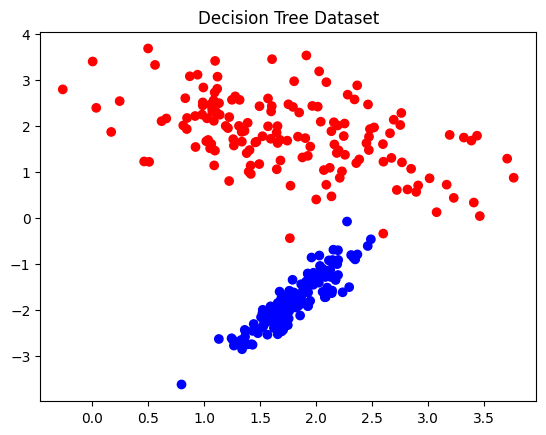

In [2]:
np.random.seed(42)


X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.8
)

y = y.reshape(-1, 1)

plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap="bwr")
plt.title("Decision Tree Dataset")
plt.show()

## 2. Helper Functions (Entropy + Info Gain)

In [3]:
def entropy(y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs + 1e-9))


def information_gain(y, y_left, y_right):
    H_parent = entropy(y)

    n = len(y)
    n_left = len(y_left)
    n_right = len(y_right)

    H_children = (n_left/n) * entropy(y_left) + (n_right/n) * entropy(y_right)

    return H_parent - H_children


## 3. Tree Node Class

In [4]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature        # feature index
        self.threshold = threshold    # threshold value
        self.left = left              # left child
        self.right = right            # right child
        self.value = value            # leaf value


## 4. Decision Tree Class

In [5]:
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    # Build the tree
    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    # Recursive builder
    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_classes = len(np.unique(y))

        # Stopping conditions
        if (depth >= self.max_depth or
            num_classes == 1 or
            num_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)

        if best_feature is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Split dataset
        left_idx = X[:, best_feature] <= best_threshold
        right_idx = ~left_idx

        left = self._grow_tree(X[left_idx], y[left_idx], depth + 1)
        right = self._grow_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(best_feature, best_threshold, left, right)

    # Find best split
    def _best_split(self, X, y):
        best_gain = -1
        split_feature, split_threshold = None, None

        n_samples, n_features = X.shape

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_idx = X[:, feature] <= t
                right_idx = ~left_idx

                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                
                gain = information_gain(y, y[left_idx], y[right_idx])

                if gain > best_gain:
                    best_gain = gain
                    split_feature = feature
                    split_threshold = t

        return split_feature, split_threshold

    # Most common class in a leaf
    def _most_common_label(self, y):
        values, counts = np.unique(y, return_counts=True)
        return values[np.argmax(counts)]

    # Prediction on one sample
    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        return self._predict_one(x, node.right)

    # Predict all
    def predict(self, X):
        return np.array([self._predict_one(x, self.root) for x in X]).reshape(-1, 1)


## 5. Train Model + Accuracy

In [6]:
dt = DecisionTree(max_depth=5)
dt.fit(X, y)

y_pred = dt.predict(X)
accuracy = np.mean(y_pred == y)

print("Accuracy:", accuracy)


Accuracy: 1.0


## 6. Decision Boundary Plot

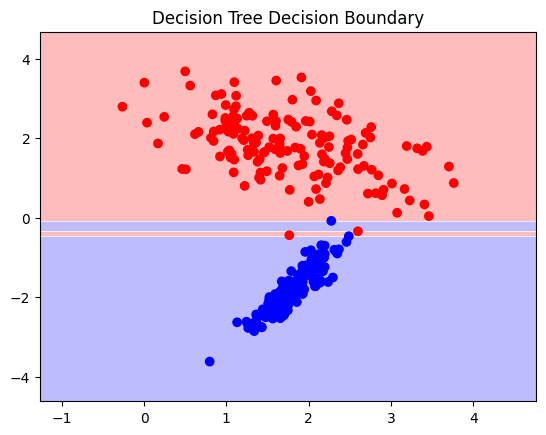

In [7]:
x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]
zz = dt.predict(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz, cmap="bwr", alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap="bwr")
plt.title("Decision Tree Decision Boundary")
plt.show()


## Model Evaluation

- The Decision Tree achieved **perfect accuracy (1.0)** on this dataset.  
- The decision boundary is **axis-aligned**, which is expected because trees split based on feature thresholds.
- Each split divides the data into rectangular regions, creating clear and interpretable partitions.
- The model strongly overfits when the dataset is clean and well-separated — which is why the boundary perfectly isolates the two classes here.
- Decision Trees are powerful but can easily overfit; depth control and pruning help prevent that.
